# Sunspot Synthesis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm,LogNorm
from numba import njit, jit, prange
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'gray'
plt.rcParams["image.interpolation"] = 'nearest'

path = './models/MURaM/sunspot/'
hdr = np.loadtxt(path+'Header.050000')
dsh = np.flip(hdr[0:3].astype(int))
dx = np.flip(hdr[3:6])
tstep = hdr[6] 
itn_str = '050000'
print('Box dimensions: ',dsh)
print('Sampling in cm: ',dx)

ztau1 = 155
height_km = (np.arange(dsh[2])-ztau1)*dx[2]/1e5 # height (km)
y_km = np.linspace(-dsh[1]/2*dx[1]/1e5,dsh[1]/2*dx[1]/1e5,dsh[1]) # y
x_km = np.linspace(-dsh[0]/2*dx[0]/1e5,dsh[0]/2*dx[0]/1e5,dsh[0]) # x
imgext = (x_km[0],x_km[-1],y_km[0],y_km[-1])
memload = lambda name: np.memmap(path + name + '.' + itn_str, dtype=np.float32, mode='r', shape=(dsh[0], dsh[1], dsh[2]))

print('loading temp')
temp = memload('eosT') # temp (K)
print('loading density')
mdens = memload('result_prim_0') # mass density
mprot = 1.672619e-24
ne = mdens / mprot * (1.+0.7)/2. # electron density (cm-3)
print('loading mag field: bz', end=' ')
bz = np.sqrt(4.*np.pi) * memload('result_prim_5') # mag field components (Ga)
print('bx', end=' ')
bx = np.sqrt(4.*np.pi) * memload('result_prim_6')
print('by', end=' ')
by = np.sqrt(4.*np.pi) * memload('result_prim_7')
print('btot', end=' ')
btot = np.sqrt(bx**2 + by**2 + bz**2) # total mag field
print('binclos', end=' ')
binclos = np.arccos(- by / btot) # inclination angle relative to surface
print('bazilos')
bazilos = np.arctan2( bx , bz) # azimuth angle
print('type matching: temp', end=' ')
temp = temp.astype(np.float32)
print('btot', end=' ')
btot = btot.astype(np.float32)
print('bz', end=' ')
bz = bz.astype(np.float32)
print('ne', end=' ')
ne = ne.astype(np.float32)
print('dx', end=' ')
dx = dx.astype(np.float32)
print('done')

Box dimensions:  [ 512 1024 1024]
Sampling in cm:  [9600000. 9600000. 4800000.]
loading temp
loading density
loading mag field: bz bx by btot binclos bazilos
type matching: temp btot bz ne dx done


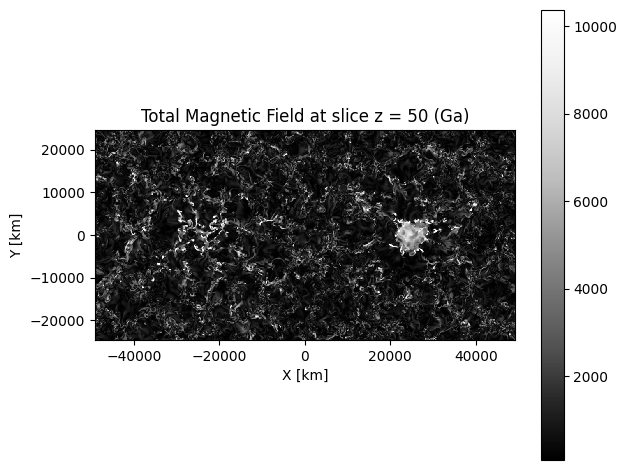

In [2]:
zidx = 50
plt.imshow(btot[:,:,zidx],extent = (y_km[0],y_km[-1],x_km[0],x_km[-1]),cmap = 'Greys_r')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.colorbar()
plt.title(f"Total Magnetic Field at slice z = {zidx} (Ga)")
plt.clim(np.nanpercentile(btot[:,:,zidx],[1,99.9]))
plt.tight_layout()

In [14]:
@njit
def for_gyrores(v, s, ne, temp, theta_rad, dl):
    # params: wave freq, harmonic n, ion density, temp, angle between B and k, line of sight component
    # return: x and o mode components of optical depth

    if s < 1 or s > 8:
        return 0.0, 0.0
    me = 9.11e-28 # g
    kB = 1.38e-16 # erg/K
    cc = 3.0e10 # cm/s
    bb = v / (2.8e6 * s)  # Gauss
    fgyro = 2.8e6 * bb # Hz
    fplasma = 8980.0 * np.sqrt(ne)  # Hz

    Y = fgyro / v
    X = (fplasma / v)**2
    delta = np.sqrt((Y * np.sin(theta_rad))**4/4.0 + (1.0 - X)**2 * (Y*np.cos(theta_rad))**2)
    calc_tee = lambda dsgn: (-(Y * np.sin(theta_rad))**2 / 2.0 - dsgn*delta) / (Y * (1.0 - X)*np.cos(theta_rad))

    coeff = (np.pi**2 / 2.0) * 8.064e7 * ne * dl / v / cc
    factorials = (1.0, 1.0, 2.0, 6.0, 24.0, 120.0, 720.0, 5040.0)
    base_factor = coeff * s**2 / factorials[s - 1] * (s**2 * np.sin(theta_rad)**2 * kB * temp / (2.0 * me * cc**2))**(s - 1)

    calc_optical_depth = lambda tee: base_factor * ((1. + tee * np.cos(theta_rad))**2 + (temp / (5.9413e9 * tee))**2) / (1. + tee**2)
    calc_gyro = lambda mode: calc_optical_depth(calc_tee(-1.0 if mode == 'x' else 1.0))

    taux = calc_gyro('x') if s != 1 else 0.0
    tauo = calc_gyro('o')
    return taux, tauo

@njit
def calc_integrands(blos, btot, ne, Te, dl, v, dogyro=False):
    f = 2.8e6 * blos/v
    f = max(min(f, 0.99), 0.01)
    dtau = 0.2 * ne**2/v**2*Te**(-3./2.)*dl
    dtaur, dtaul = dtau/(1.-f)**2., dtau/(1.+f)**2.
    # if abs(f) > 0.95:
    #     dtaur, dtaul = 0.0, 0.0
    if btot > 0 and dogyro:
        s_eff = v / (2.8e6 * btot)
        s = int(np.round(s_eff))
        if 1 <= s <= 8 and np.abs(s - s_eff) < 0.2:
            theta_rad = np.arccos(min(max(blos / btot, -1.0), 1.0))
            taux, tauo = for_gyrores(v, s, ne, Te, theta_rad, dl)
            if blos < 0:
                taux, tauo = tauo, taux
            dtaur += taux
            dtaul += tauo
    return dtaur, dtaul

@njit
def calc_radiative_transfer(dtaur, dtaul, Te, Tbr, Tbl):
    Tbr, Tbl = Tbr*np.exp(-dtaur)+Te*(1.-np.exp(-dtaur)), Tbl*np.exp(-dtaul)+Te*(1.-np.exp(-dtaul))
    return Tbr, Tbl

@njit(parallel=True)
def radio_integrate(temp, btot, bz, ne, dl, v, dogyro=False):
    shp = temp.shape
    pdl = dl
    IV = np.zeros((2, shp[0], shp[1])) # stokes IV
    THK = np.zeros((shp[0], shp[1])) # optical thickness
    INT = np.zeros((shp[0], shp[1], shp[2], 2)) # integrands
    for ix in prange(shp[0]):
        for iy in prange(shp[1]):
            Tbr = Tbl = 3.0
            taur = taul = 0.0
            for iz in range(0, shp[2]): # iterating thru z
                ptemp = temp[ix, iy, iz]
                pblos = bz[ix, iy, iz]
                pbtot = btot[ix, iy, iz]
                pne = ne[ix, iy, iz]

                dtaur, dtaul = calc_integrands(pblos, pbtot, pne, ptemp, pdl, v, dogyro)
                INT[ix, iy, iz] = dtaur, dtaul
                # radiative transfer should automatically handle dtaur, dtaul -> inf limit
                Tbr, Tbl = calc_radiative_transfer(dtaur, dtaul, ptemp, Tbr, Tbl)
            I = (Tbr + Tbl) / 2.
            V = (Tbr - Tbl) / 2.
            IV[0, ix, iy] = I
            IV[1, ix, iy] = V
            for iz in range(shp[2] - 1, -1, -1):
                dtaur, dtaul = INT[ix, iy, iz]
                taul += dtaul
                taur += dtaur
                if (taul + taur)/2 >= 1.0 and THK[ix, iy] == 0.0:
                    THK[ix, iy] = dl*(shp[2] - iz)
                    break
            if (THK[ix, iy] == 0.0):
                THK[ix, iy] = dl*shp[2] - dl # never reaches thickness
    return IV, THK

v = 1e9
v = np.float32(v)
dl = dx[2]
IV, THK = radio_integrate(temp, btot, bz, ne, dl, v, True)
kb = 1.3807e-16
cc = 299792458 * 100.
tb_to_flux = lambda t: 2*kb*t*v**2/cc**2*1e23

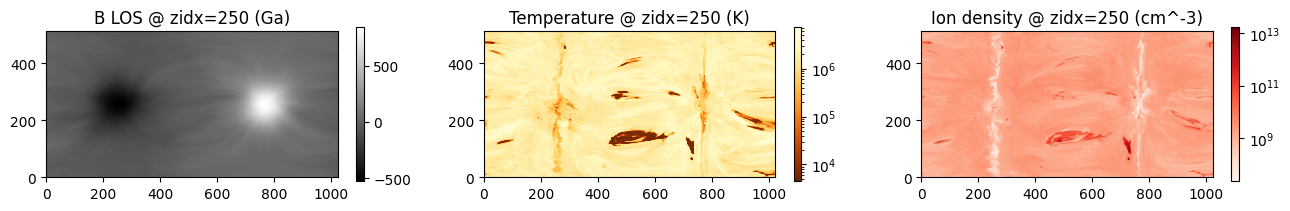

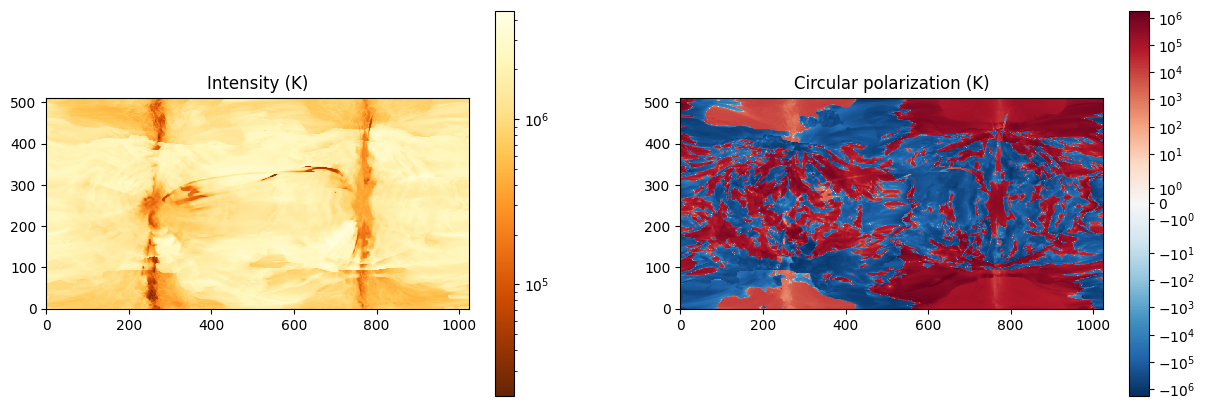

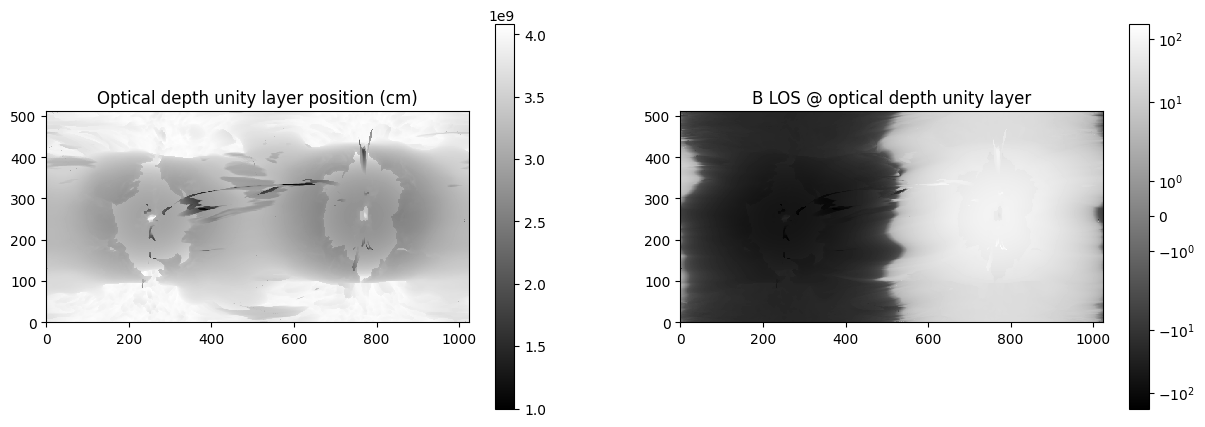

In [4]:
zidx = 250
fig, ax = plt.subplots(1, 3, figsize=(16, 2))
ax[0].set_title(f'B LOS @ zidx={zidx} (Ga)')
im0 = ax[0].imshow(bz[:, :, zidx], cmap='gray')
fig.colorbar(im0, ax=ax[0])
ax[1].set_title(f'Temperature @ zidx={zidx} (K)')
im1 = ax[1].imshow(temp[:, :, zidx], norm='log', cmap='YlOrBr_r')
fig.colorbar(im1, ax=ax[1])
ax[2].set_title(f'Ion density @ zidx={zidx} (cm^-3)')
im2 = ax[2].imshow(ne[:, :, zidx], norm='log', cmap='Reds')
fig.colorbar(im2, ax=ax[2])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Intensity (K)')
im0 = ax[0].imshow(IV[0], norm='log', cmap='YlOrBr_r')
fig.colorbar(im0, ax=ax[0])
ax[1].set_title('Circular polarization (K)')
im1 = ax[1].imshow(IV[1], norm='symlog', cmap='RdBu_r')
fig.colorbar(im1, ax=ax[1])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Optical depth unity layer position (cm)')
im0 = ax[0].imshow(THK, cmap='gray')
fig.colorbar(im0, ax=ax[0])

qatidx = lambda q, z: q[np.arange(q.shape[0])[:, None], np.arange(q.shape[1]), z]
ax[1].set_title('B LOS @ optical depth unity layer')
im1 = ax[1].imshow(qatidx(bz, np.floor(THK/dl).astype(np.int32)), cmap='gray', norm='symlog')
fig.colorbar(im1, ax=ax[1])

In [5]:
%%script true
import matplotlib.animation as animation
from tqdm import tqdm

vs = 10**np.linspace(6, 11, 100)
format_freq = lambda f: f"{int(f//10**(3*(k:=int(np.log10(f)//3))))}{' kMGT'[k].replace(' ', '')}Hz"

@njit(parallel=True)
def radio_integrate_thickness(temp, btot, bz, ne, dl, v, dogyro=False):
    shp = temp.shape
    pdl = dl
    THK = np.zeros((shp[0], shp[1])) # optical thickness
    INT = np.zeros((shp[0], shp[1], shp[2], 2)) # integrands
    for ix in prange(shp[0]):
        for iy in prange(shp[1]):
            taur = taul = 0.0
            for iz in range(0, shp[2]): # iterating thru z
                ptemp = temp[ix, iy, iz]
                pblos = bz[ix, iy, iz]
                pbtot = btot[ix, iy, iz]
                pne = ne[ix, iy, iz]
                dtaur, dtaul = calc_integrands(pblos, pbtot, pne, ptemp, pdl, v, dogyro)
                INT[ix, iy, iz] = dtaur, dtaul
            for iz in range(shp[2] - 1, -1, -1):
                dtaur, dtaul = INT[ix, iy, iz]
                taul += dtaul
                taur += dtaur
                if (taul + taur)/2 >= 1.0 and THK[ix, iy] == 0.0:
                    THK[ix, iy] = dl*(shp[2] - iz)
                    break
            if (THK[ix, iy] == 0.0):
                THK[ix, iy] = dl*shp[2] - dl
    return THK

results = []
vmin, vmax = np.inf, -np.inf
bzmin, bzmax = np.inf, -np.inf
for v in tqdm(vs):
    THK = radio_integrate_thickness(temp, btot, bz, ne, dl, v.astype(np.float32), False)
    vmin = min(vmin, THK.min())
    vmax = max(vmax, THK.max())
    i_unity = np.clip((dsh[2] - THK / dl).astype(np.int32), 0, temp.shape[2] - 1)
    ix, iy = np.indices(i_unity.shape)
    bz_at_unity = bz[ix, iy, i_unity]
    bzmin = min(bzmin, bz_at_unity.min())
    bzmax = max(bzmax, bz_at_unity.max())
    results.append((v, THK, bz_at_unity))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
vmin /= 1e8
vmax /= 1e8

im1 = axs[0].imshow(np.zeros((dsh[0], dsh[1])), cmap='nipy_spectral', animated=True, vmin=vmin, vmax=vmax)
title1 = axs[0].set_title("")
cbar1 = fig.colorbar(im1, ax=axs[0], shrink=0.5)
cbar1.set_label("Distance from solar surface (Mm)")

im2 = axs[1].imshow(np.zeros((dsh[0], dsh[1])), cmap='RdBu_r', animated=True, vmin=bzmin, vmax=bzmax, norm='symlog')
title2 = axs[1].set_title("")
cbar2 = fig.colorbar(im2, ax=axs[1], shrink=0.5)
cbar2.set_label("B LOS at optical unity layer (G)")

fig.tight_layout()

def update(frame):
    v, THK, bz_at_unity = results[frame]
    im1.set_array((dsh[2]*dl - THK)/1e8)
    title1.set_text(f'Optical depth unity layer @ {format_freq(v)}')
    im2.set_array(bz_at_unity)
    title2.set_text(f'B LOS at optical depth unity layer @ {format_freq(v)}')
    return [im1, title1, im2, title2]

anim = animation.FuncAnimation(fig, update, frames=len(results), blit=True, interval=100)
anim.save("optical-depth-unity-blos.mp4", fps=5, dpi=150, extra_args=["-vcodec", "libx264"])

Couldn't find program: 'true'


# Inversion

C:\Users\cgraham\AppData\Local\Temp\ipykernel_8564\2594088656.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ts[ii] = t
C:\Users\cgraham\AppData\Local\Temp\ipykernel_8564\2594088656.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tbs[ii] = Tb


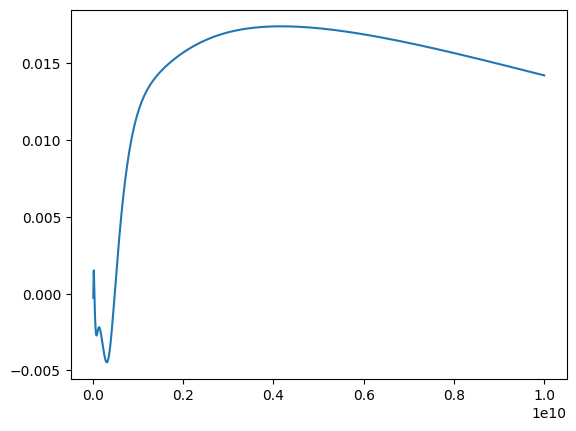

[0.01422005] -0.03674839283017467 -0.026870985641718016


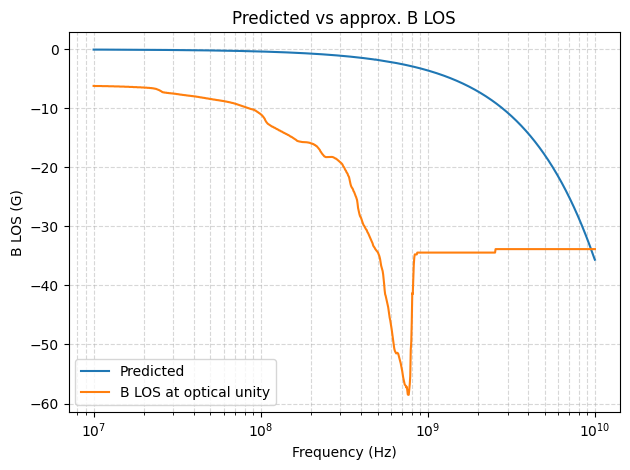

In [ ]:
# inversion
ix, iy = 100, 100
n = 1000
vs = np.logspace(7, 10, n)
bs = np.zeros(n)
ts = np.zeros(n)
Tbs = np.zeros(n)
ps = np.zeros(n)
t1 = temp[ix:ix + 1, iy:iy + 1, :]
b1 = btot[ix:ix + 1, iy:iy + 1, :]
bl1 = bz[ix:ix + 1, iy:iy + 1, :]
ne1 = ne[ix:ix + 1, iy:iy + 1, :]

for ii in range(n):
    IV, THK = radio_integrate(t1, b1, bl1, ne1, dl, vs[ii], False)
    I = IV[0]
    Tb = I
    V = IV[1]
    P = (V/I)[0, 0]
    ps[ii] = P
    blos = P/2.8e6*vs[ii]
    b = blos
    t = THK
    bs[ii] = b
    ts[ii] = t
    Tbs[ii] = Tb

n1 = -np.gradient(np.log10(Tbs), np.log10(vs))
bs /= n1
print(IV[1][0]/IV[0][0], bs[0], n1[0])

plt.figure()
plt.plot(vs, bs, label='Predicted', color='tab:blue')
actual_blos = bl1[0, 0, dsh[2] - np.round(ts/dl).astype(np.int32)]
plt.plot(vs, actual_blos, label='B LOS at optical unity', color='tab:orange')
plt.xlabel('Frequency (Hz)')
plt.ylabel('B LOS (G)')
plt.xscale('log')
plt.title('Predicted vs approx. B LOS')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Slice

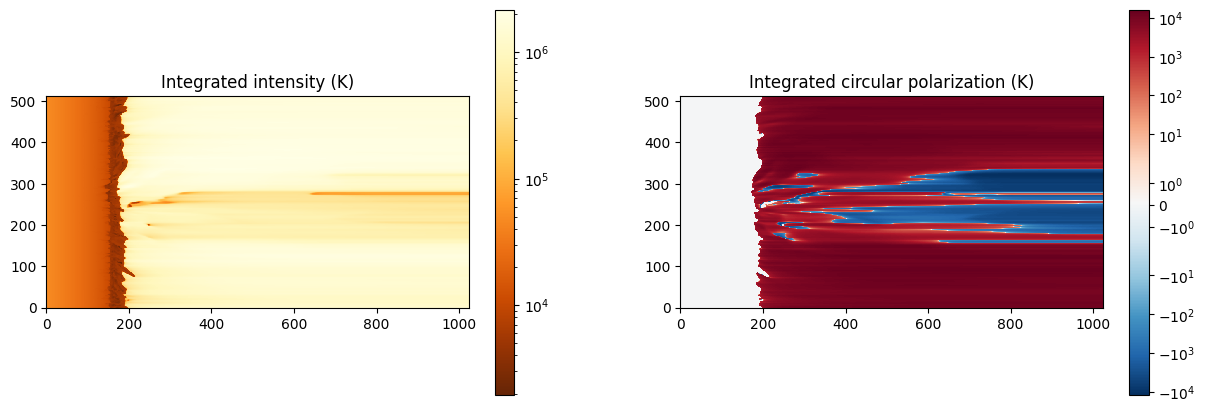

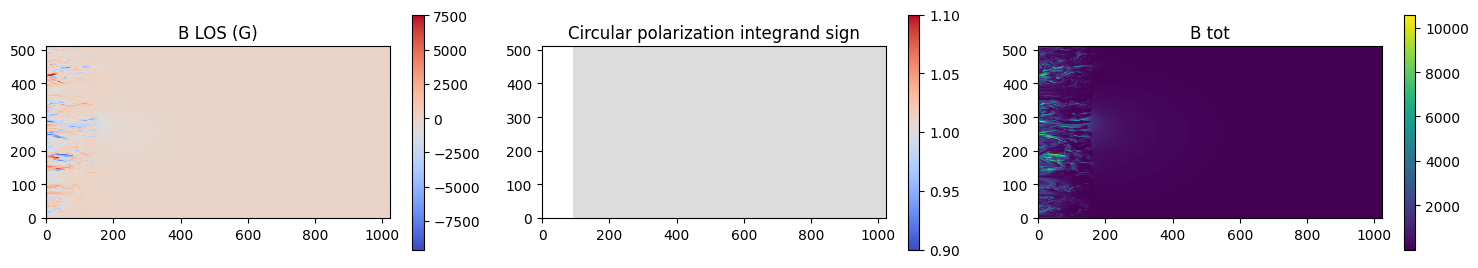

In [7]:
@njit(parallel=True)
def radio_integrate_slice(temp, btot, bz, ne, dl, v, yidx = 0, dogyro=False):
    shp = temp.shape
    pdl = dl
    IV = np.zeros((2, shp[0], shp[2])) # stokes IV
    THK = np.zeros((shp[0], shp[2]))
    for ix in prange(shp[0]):
        Tbr = Tbl = 3.0
        taur = taul = 0.0
        for iz in range(0, shp[2]): # iterating thru z
            ptemp = temp[ix, yidx, iz]
            pblos = bz[ix, yidx, iz]
            pbtot = btot[ix, yidx, iz]
            pne = ne[ix, yidx, iz]

            dtaur, dtaul = calc_integrands(pblos, pbtot, pne, ptemp, pdl, v, dogyro)
            # if not np.isinf(dtaur) and not np.isinf(dtaul):
            Tbr, Tbl = calc_radiative_transfer(dtaur, dtaul, ptemp, Tbr, Tbl)
            if not np.isinf(dtaur) and not np.isinf(dtaul):
                taul += dtaul
                taur += dtaur
            THK[ix, iz] = (dtaur - dtaul)/2
            # if (random.randint(0, 100000) == 0 and iz < 100):
            #     print(dtaur, dtaul)
            I = (Tbr + Tbl) / 2.
            V = (Tbr - Tbl) / 2.
            IV[0, ix, iz] = I
            IV[1, ix, iz] = V
    return IV, THK

v=4e8 #1e3 and 1e12
yidx = 300 # 300 and 800
IV, THK = radio_integrate_slice(temp, btot, bz, ne, dl, v, yidx, False)
BLOS = bz[:, yidx, :]
BTOT = btot[:, yidx, :]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Integrated intensity (K)')
im0 = ax[0].imshow(IV[0], norm='log', cmap='YlOrBr_r')
fig.colorbar(im0, ax=ax[0])
ax[1].set_title('Integrated circular polarization (K)')
im1 = ax[1].imshow(IV[1], norm='symlog', cmap='RdBu_r')
fig.colorbar(im1, ax=ax[1])
from matplotlib.colors import SymLogNorm
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].set_title('B LOS (G)')
im0 = ax[0].imshow(BLOS, cmap='coolwarm')
fig.colorbar(im0, ax=ax[0], shrink=0.5)
ax[1].set_title('Circular polarization integrand sign')
im1 = ax[1].imshow(np.sign(THK), cmap='coolwarm')
fig.colorbar(im1, ax=ax[1], shrink=0.5)
ax[2].set_title('B tot')
im1 = ax[2].imshow(BTOT, cmap='viridis') #(np.sign(THK) != np.sign(T)) & (~np.isnan(THK))
fig.colorbar(im1, ax=ax[2], shrink=0.5)
fig.tight_layout()

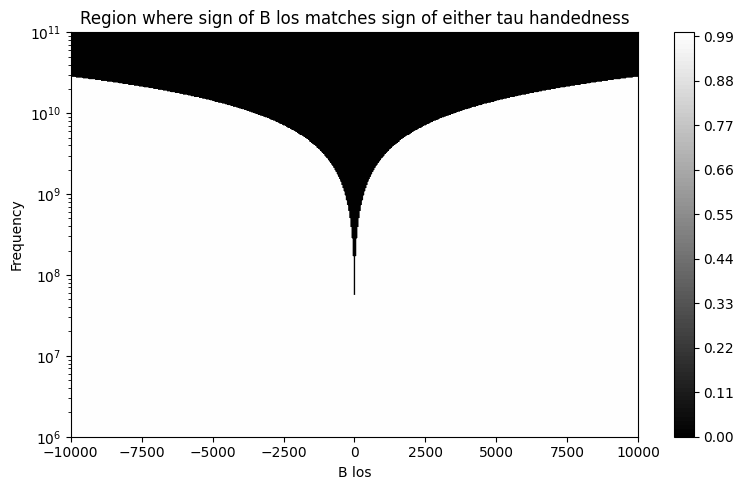

In [8]:
def z_func(b, v):
    f = 2.8e6 * b / v
    return (np.sign(1/(1-f) - 1/(1+f)) != np.sign(b))

b = np.linspace(-10000, 10000, 500)
v = np.logspace(6, 11, 500)
B, V = np.meshgrid(b, v)
Z = z_func(B, V)

plt.figure(figsize=(8, 5))
plt.yscale('log')
plt.colorbar(plt.contourf(B, V, Z, levels=100, cmap='gray'))
plt.xlabel('B los')
plt.ylabel('Frequency')
plt.title('Region where sign of B los matches sign of either tau handedness')
plt.tight_layout()
plt.show()

C:\Users\cgraham\AppData\Local\Temp\ipykernel_8564\285984188.py:2: RuntimeWarning: divide by zero encountered in divide
  s_eff = v / (2.8e6 * b)
C:\Users\cgraham\AppData\Local\Temp\ipykernel_8564\285984188.py:4: RuntimeWarning: invalid value encountered in subtract
  return (s >= 1) & (s <= 8) & (np.abs(s - s_eff) < 0.2)


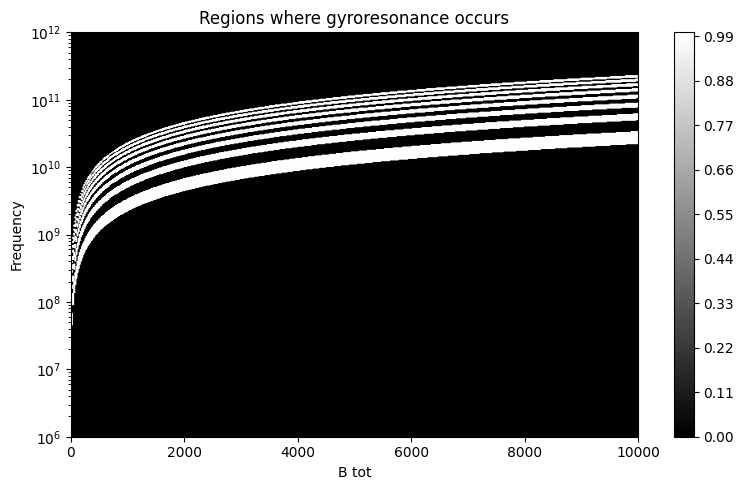

In [9]:
def z_func(b, v):
    s_eff = v / (2.8e6 * b)
    s = np.round(s_eff)
    return (s >= 1) & (s <= 8) & (np.abs(s - s_eff) < 0.2)

b = np.linspace(0, 10000, 500)
v = np.logspace(6, 12, 500)
B, V = np.meshgrid(b, v)
Z = z_func(B, V)

plt.figure(figsize=(8, 5))
plt.yscale('log')
plt.colorbar(plt.contourf(B, V, Z, levels=100, cmap='gray'))
plt.xlabel('B tot')
plt.ylabel('Frequency')
plt.title('Regions where gyroresonance occurs')
plt.tight_layout()
plt.show()

In [10]:
# model presentation

@njit
def for_gyrores(v, s, ne, temp, theta_rad, dl):
    # params: wave freq, harmonic n, ion density, temp, angle between B and k, line of sight component
    # return: x and o mode components of optical depth

    if s < 1 or s > 8:
        return 0.0, 0.0
    me = 9.11e-28 # g
    kB = 1.38e-16 # erg/K
    cc = 3.0e10 # cm/s
    bb = v / (2.8e6 * s)  # Gauss
    fgyro = 2.8e6 * bb # Hz
    fplasma = 8980.0 * np.sqrt(ne)  # Hz

    Y = fgyro / v
    X = (fplasma / v)**2
    delta = np.sqrt((Y * np.sin(theta_rad))**4/4.0 + (1.0 - X)**2 * (Y*np.cos(theta_rad))**2)
    calc_tee = lambda dsgn: (-(Y * np.sin(theta_rad))**2 / 2.0 - dsgn*delta) / (Y * (1.0 - X)*np.cos(theta_rad))

    coeff = (np.pi**2 / 2.0) * 8.064e7 * ne * dl / v / cc
    factorials = (1.0, 1.0, 2.0, 6.0, 24.0, 120.0, 720.0, 5040.0)
    base_factor = coeff * s**2 / factorials[s - 1] * (s**2 * np.sin(theta_rad)**2 * kB * temp / (2.0 * me * cc**2))**(s - 1)

    calc_optical_depth = lambda tee: base_factor * ((1. + tee * np.cos(theta_rad))**2 + (temp / (5.9413e9 * tee))**2) / (1. + tee**2)
    calc_gyro = lambda mode: calc_optical_depth(calc_tee(-1.0 if mode == 'x' else 1.0))

    taux = calc_gyro('x') if s != 1 else 0.0
    tauo = calc_gyro('o')
    return taux, tauo

@njit
def calc_integrands(blos, btot, ne, Te, dl, v, dogyro=False):
    f = 2.8e6 * blos/v
    dtau = 0.2 * ne**2/v**2*Te**(-3./2.)*dl
    dtaur, dtaul = dtau/(1.-f)**2., dtau/(1.+f)**2.
    if btot > 0 and dogyro:
        s_eff = v / (2.8e6 * btot)
        s = int(np.round(s_eff))
        if 1 <= s <= 8 and np.abs(s - s_eff) < 0.2:
            theta_rad = np.arccos(min(max(blos / btot, -1.0), 1.0))
            taux, tauo = for_gyrores(v, s, ne, Te, theta_rad, dl)
            if blos < 0:
                taux, tauo = tauo, taux
            dtaur += taux
            dtaul += tauo
    return dtaur, dtaul

@njit
def calc_radiative_transfer(dtaur, dtaul, Te, Tbr, Tbl):
    Tbr, Tbl = Tbr*np.exp(-dtaur)+Te*(1.-np.exp(-dtaur)), Tbl*np.exp(-dtaul)+Te*(1.-np.exp(-dtaul))
    return Tbr, Tbl

@njit(parallel=True)
def radio_integrate(temp, btot, bz, ne, dl, v, dogyro=False):
    """
    Integrate through LOS-component of B field given temperature, total B field, LOS B field, length differential, and frequency
    """
    shp = temp.shape
    pdl = dl
    IV = np.zeros((2, shp[0], shp[1])) # stokes IV
    for ix in prange(shp[0]): # parallel ok for memory writes to diff loc
        for iy in prange(shp[1]): # ditto
            Tbr = Tbl = 3.0
            for iz in range(0, shp[2]): # integrate thru z axis (no parallel - avoid race conditions)
                # collect parameters
                ptemp = temp[ix, iy, iz] # temp param
                pblos = bz[ix, iy, iz] # LOS-component of mag field param
                pbtot = btot[ix, iy, iz] # total b field param
                pne = ne[ix, iy, iz] # ion density param

                dtaur, dtaul = calc_integrands(pblos, pbtot, pne, ptemp, pdl, v, dogyro)
                # radiative transfer should automatically handle dtaur, dtaul -> inf limit (for low corona)
                Tbr, Tbl = calc_radiative_transfer(dtaur, dtaul, ptemp, Tbr, Tbl)
            I = (Tbr + Tbl) / 2.
            V = (Tbr - Tbl) / 2.
            IV[0, ix, iy] = I
            IV[1, ix, iy] = V
    return IV